# Analyze eGFP indels

In [1]:
import os
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib import cm
from matplotlib import colors
import matplotlib.patches as mpatches
import multiprocessing as mp
import matplotlib.image as image
from Bio import SeqIO, Seq
import gzip
import seaborn as sns
from glob import glob
import bz2
from matplotlib import ticker
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['figure.dpi']= 300

## Read data

In [2]:
datadir = 'pileups_indels/'

ampl_name = 'GFP'

indel_counts = pd.read_csv(os.path.join(datadir, '{}_indel_read_counts_UMI_5.tsv'.format(ampl_name)), sep='\t', index_col=0)
indel_counts.loc[['GFP-EMPTY_S1', 'GFP-1_S2', 'GFP-1-B_S3']]

,Insertions,Deletions
GFP-EMPTY_S1,1,24
GFP-1_S2,1085,5098
GFP-1-B_S3,42156,153966


In [3]:
insertion_files = glob(os.path.join(datadir, 'GFP*_insertions_by_UMI_5.tsv.bz2'))
insertion_files.sort()
insertion_files = insertion_files[::-1]

insertion_data = {f.split('/')[-1].replace('_insertions_by_UMI_5.tsv.bz2', ''):pd.read_csv(bz2.open(f, 'rt'), sep='\t', index_col=0)
                 for f in insertion_files}

In [4]:
deletion_files = glob(os.path.join(datadir, 'GFP*_deletions_by_UMI_5.tsv.bz2'))
deletion_files.sort()
deletion_files = deletion_files[::-1]

deletion_data = {f.split('/')[-1].replace('_deletions_by_UMI_5.tsv.bz2', ''):pd.read_csv(bz2.open(f, 'rt'), sep='\t', index_col=0)
                 for f in deletion_files}

In [5]:
insertion_data = {f:insertion_data[f]['0'].apply(eval) for f in ['GFP-EMPTY_S1', 'GFP-1_S2', 'GFP-1-B_S3']}
deletion_data = {f:deletion_data[f]['0'].apply(eval) for f in ['GFP-EMPTY_S1', 'GFP-1_S2', 'GFP-1-B_S3']}

## Read amplicons

In [6]:
basedir = './'

spike = str([rec.seq for rec in SeqIO.parse(os.path.join(basedir, 'amplicons/spike.fasta'), 'fasta')][0])
EGFP = str([rec.seq for rec in SeqIO.parse(os.path.join(basedir, 'amplicons/EGFP.fasta'), 'fasta')][0])

EGFP_F_S = 'CGAGCTGAAGGGCATCGAC'
EGFP_R_S = 'CTCGTCCATGCCGAGAGTGA'
EGFP_amplicon_S = EGFP[EGFP.find(EGFP_F_S):EGFP.find(str(Seq.Seq(EGFP_R_S).reverse_complement()))+len(EGFP_R_S)]

spike_F_S = 'TGCCATCGGCAAGATTCAAG'
spike_R_S = 'TGCCACAAAAGTCGACCCG'
spike_amplicon_S = spike[spike.find(spike_F_S):spike.find(str(Seq.Seq(spike_R_S).reverse_complement()))+len(spike_R_S)]

ampls = {'GFP':EGFP, 'spike':spike}

ampl_name = 'spike' if list(insertion_data.keys())[0].startswith('SPIKE') else 'GFP'

guide_seq = {'GFP':{'B':'caacgagaagcgcgatcaca', '1':'gagcTaagaccccaacgaga'}, 'spike':{'1':'CGACCCACCGGAAGCAGAAG',
                                                                                      'B':'CAAATTGATCGCCTGATAAC'}}
guide_pos = {ampl:{g:ampls[ampl].find(guide_seq[ampl][g].upper()) for g in guide_seq[ampl]} for ampl in guide_seq}
guides_by_sample = {
    'GFP-EMPTY_S1':['1'],
    'GFP-1_S2':['1'],
    'GFP-1-B_S3':['1', 'B'],
    'SPIKE-RT-EMPTY_S9':['1', 'B'],
    'SPIKE-RT-1-B_S10':['1', 'B'],
    'SPIKE-EVO-EMPTY_S11':['1', 'B'],
    'SPIKE-EVO-1-B_S12':['1', 'B']
}
nick_sites = {f:{g:guide_pos[ampl_name][g]+2.5 if g!='B' else guide_pos[ampl_name][g]+16.5 for g in guides_by_sample[f]}
              for f in insertion_data}

In [7]:
ampl_coords = {'GFP':(EGFP.find(EGFP_amplicon_S), EGFP.find(EGFP_amplicon_S)+len(EGFP_amplicon_S)),
    'spike':(spike.find(spike_amplicon_S), spike.find(spike_amplicon_S)+len(spike_amplicon_S))}

## Read number of UMIs

In [8]:
UMI_counts = pd.read_csv('UMI_indel_ratio.tsv', sep='\t', index_col=0)

## Indel distribution

In [9]:
deletion_data_counts = {}
for f in deletion_data:
    deletion_data_counts[f] = []
    for pos in deletion_data[f].index:
        for UMI in deletion_data[f].loc[pos]:
            for i in range(pos, pos+deletion_data[f].loc[pos][UMI]):
                deletion_data_counts[f].append(i)

deletion_data_counts = {f:pd.Series(Counter(deletion_data_counts[f])) for f in deletion_data_counts}
for f in deletion_data_counts:
    for i in range(*ampl_coords[ampl_name]):
        if i not in deletion_data_counts[f].index:
            deletion_data_counts[f].loc[i] = 0
deletion_data_counts = {f:deletion_data_counts[f].sort_index() for f in deletion_data_counts}

In [10]:
to_plot_in = {f:insertion_data[f].apply(len).divide(UMI_counts.loc[f, 'Total']) for f in insertion_data}
to_plot_del = {f:deletion_data_counts[f].divide(UMI_counts.loc[f, 'Total']) for f in insertion_data}

In [11]:
for f in to_plot_del:
    to_plot_del[f].name = 'Deletions'
for f in to_plot_in:
    to_plot_in[f].name = 'Insertions'

In [12]:
titles = {
    'GFP-EMPTY_S1':'Polλ Δ2 R438W + non-targeting guide',
    'GFP-1_S2':'Polλ Δ2 R438W + single guide',
    'GFP-1-B_S3':'Polλ Δ2 R438W + double guides'
}

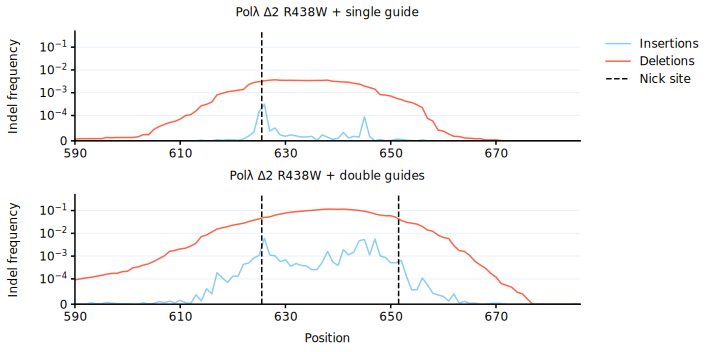

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))

for n,f in enumerate(['GFP-1_S2', 'GFP-1-B_S3']):
    to_plot_in[f].plot(color='lightskyblue', ax=ax[n])
    to_plot_del[f].plot(color='tomato', ax=ax[n])
    ymax = 0.5
    ax[n].set_ylim(0, ymax)
    ax[n].set_yscale('symlog', linthresh=1e-4)
    ax[n].set_xlim(625-35, 651+35)
    ax[n].set_xticks([i for i in range(625-35, 651+35, 20)])
    ax[n].set_xticklabels([i for i in range(625-35, 651+35, 20)], size=12, rotation=0)
    for y in ax[n].get_yticklabels():
        y.set_size(12)
    ax[n].set_title(titles[f], size=12, pad=15)
    ax[n].spines['right'].set_visible(False)
    ax[n].spines['left'].set_linewidth(1.5)
    ax[n].spines['top'].set_visible(False)
    ax[n].spines['bottom'].set_linewidth(1.5)
    ax[n].tick_params(width=1.5, length=4)
    ax[n].set_ylabel('Indel frequency', size=12, labelpad=20, color='k')
    guide_names = guides_by_sample[f]
    for guide_name in guide_names:
        nick = nick_sites[f][guide_name]
        if guide_name=='B':
            ax[n].vlines(nick, 0, ymax, color='k', linestyle='--')
        else:
            ax[n].vlines(nick, 0, ymax, color='k', linestyle='--',label='Nick site')
    for i in range(1,5):
        ax[n].hlines(10**(-i), 0, len(ampls[ampl_name]), linewidth=1, alpha=0.1)
    ax[n].set_yticks([], minor=True)
    ax[n].set_yticks([10**(-x) for x in range(1, 5)]+[0])

lgd = ax[0].legend(loc='upper left', bbox_to_anchor=(1.03, 1.03), title ='', prop={'size':12}, ncol=1, frameon=False)
plt.setp(lgd.get_title(),fontsize='12')
ax[-1].set_xlabel('Position', size=12, labelpad=10)
    
plt.tight_layout()
plt.show()

## Count indels near nicks

In [14]:
control = 'GFP-EMPTY_S1'

In [15]:
indel_window = 20

In [16]:
nick_sites = {f:{g:int(nick_sites[f][g]+0.5) for g in nick_sites[f]} for f in nick_sites}

In [17]:
insertions_in_window = {g:{} for g in ['1', '1+B']}
deletions_in_window = {g:{} for g in ['1', '1+B']}
for f in insertion_data:
    for g in insertions_in_window:
        if 'B' not in nick_sites[f]:
            if g in nick_sites[f]:
                nick = nick_sites[f][g]
                insertions_in_window[g][control] = set(np.unique([UMI for pos_data in insertion_data[control][
                    nick-indel_window:nick+indel_window].values for UMI in pos_data]))
                insertions_in_window[g][f] = set(np.unique([UMI for pos_data in insertion_data[f][
                    nick-indel_window:nick+indel_window].values for UMI in pos_data]))
                
                deletions_in_window[g][control] = set(np.unique([UMI for pos in deletion_data[control].index
                    for UMI in deletion_data[control].loc[pos] if pos<nick+indel_window and pos+deletion_data[control].loc[pos][
                        UMI]>nick-indel_window]))
                deletions_in_window[g][f] = set(np.unique([UMI for pos in deletion_data[f].index
                    for UMI in deletion_data[f].loc[pos] if pos<nick+indel_window and pos+deletion_data[f].loc[pos][
                        UMI]>nick-indel_window]))
        else:
            if g=='1+B' and 'B' in f:
                insertions_in_window[g][control] = set(np.unique([UMI for pos_data in insertion_data[control][
                    nick_sites[f]['1']-indel_window:nick_sites[f]['B']+indel_window].values for UMI in pos_data]))
                insertions_in_window[g][f] = set(np.unique([UMI for pos_data in insertion_data[f][
                    nick_sites[f]['1']-indel_window:nick_sites[f]['B']+indel_window].values for UMI in pos_data]))
                
                deletions_in_window[g][control] = set(np.unique([UMI for pos in deletion_data[control].index
                    for UMI in deletion_data[control].loc[pos] if pos<nick_sites[f]['B']+indel_window and pos+deletion_data[
                        control].loc[pos][UMI]>nick_sites[f]['1']-indel_window]))
                deletions_in_window[g][f] = set(np.unique([UMI for pos in deletion_data[f].index for UMI in deletion_data[f].loc[pos]
                    if pos<nick_sites[f]['B']+indel_window and pos+deletion_data[f].loc[pos][UMI]>nick_sites[f]['1']-indel_window]))

In [18]:
indel_in_window_UMIs = {g:{f:[UMI for UMI in insertions_in_window[g][f] if UMI in deletions_in_window[g][f]]
                               for f in insertions_in_window[g]} for g in insertions_in_window}
insertions_in_window_UMIs = {g:{f:[UMI for UMI in insertions_in_window[g][f] if UMI not in deletions_in_window[g][f]]
                               for f in insertions_in_window[g]} for g in insertions_in_window}
deletions_in_window_UMIs = {g:{f:[UMI for UMI in deletions_in_window[g][f] if UMI not in insertions_in_window[g][f]]
                               for f in insertions_in_window[g]} for g in insertions_in_window}

In [19]:
indel_in_window_fraction = {g:{f:len([UMI for UMI in insertions_in_window[g][f] if UMI in deletions_in_window[g][f]])/UMI_counts.loc[f, 'Total']
                               for f in insertions_in_window[g]} for g in insertions_in_window}
insertions_in_window_fraction = {g:{f:len([UMI for UMI in insertions_in_window[g][f] if UMI not in deletions_in_window[g][f]])/UMI_counts.loc[f, 'Total']
                               for f in insertions_in_window[g]} for g in insertions_in_window}
deletions_in_window_fraction = {g:{f:len([UMI for UMI in deletions_in_window[g][f] if UMI not in insertions_in_window[g][f]])/UMI_counts.loc[f, 'Total']
                               for f in insertions_in_window[g]} for g in insertions_in_window}

In [20]:
indel_fract = {g:{f:pd.Series([deletions_in_window_fraction[g][f], insertions_in_window_fraction[g][f], indel_in_window_fraction[g][f]],
    index=['Deletions', 'Insertions', 'Insertions and\nDeletions']) for f in insertions_in_window_fraction[g]} 
    for g in insertions_in_window_fraction}

In [21]:
for g in indel_fract:
    for f in indel_fract[g]:
        indel_fract[g][f]['No Indels'] = 1-indel_fract[g][f].sum()

In [22]:
indel_fract_dfs = {g:pd.DataFrame(indel_fract[g]) for g in indel_fract}

In [23]:
to_plot = pd.concat([indel_fract_dfs['1+B']['GFP-EMPTY_S1'], indel_fract_dfs['1']['GFP-1_S2'], indel_fract_dfs['1+B']['GFP-1-B_S3']], axis=1)

In [24]:
to_plot

,GFP-EMPTY_S1,GFP-1_S2,GFP-1-B_S3
Deletions,0.000002,0.004405,0.153402
Insertions,0.000000,0.000596,0.037900
Insertions and\nDeletions,0.000000,0.000378,0.005527
No Indels,0.999998,0.994621,0.803171


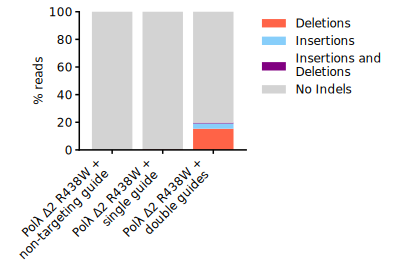

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 2.5))


to_plot.transpose().multiply(100).plot(kind='bar', stacked=True, legend=False, ax=ax, width=0.8,
                                        color = ['lightgray', 'purple', 'lightskyblue', 'tomato'][::-1])

ax.set_xticklabels([titles[x.get_text()].replace('+', '+\n') for x in ax.get_xticklabels()], rotation = 45, ha='right', size=12)
ax.set_ylabel('% reads', size=12)
lgd = ax.legend(loc='upper left', bbox_to_anchor=(1.03, 1.03), frameon=False, title ='', prop={'size':12}, ncol=1)

ax.set_ylim(0,100)
#ax.set_yscale('symlog', linthresh=0.01)
for y in ax.get_yticklabels():
    y.set_size(12)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(width=1.5, length=4)

plt.show()

## Indel length

In [26]:
insertion_len = {f:[l for d in insertion_data[f].values for l in d.values()] for f in insertion_data}

In [27]:
insertion_len = {f:pd.Series(Counter(insertion_len[f])).sort_index(ascending=True) for f in insertion_data}

In [28]:
deletion_len = {f:[l for d in deletion_data[f].values for l in d.values()] for f in deletion_data}

In [29]:
deletion_len = {f:pd.Series(Counter(deletion_len[f])).sort_index(ascending=True) for f in deletion_data}

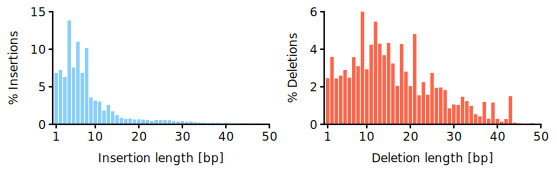

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 2.5), gridspec_kw={'width_ratios': [5, 5]})

sample = 'GFP-1-B_S3'
insertion_len[sample].divide(insertion_len[sample].sum()/100).plot(kind='bar',ax=ax[0], color='lightskyblue', width=0.8)
ax[0].set_xlim(-0.5, max(insertion_len[sample].index))
ax[0].set_xticks([0] + [x for x in range(9, max(insertion_len[sample].index),10)])
ax[0].set_xticklabels([1] + [x+1 for x in range(9, max(insertion_len[sample].index),10)], size=12, rotation=0)
ax[0].set_xlabel('Insertion length [bp]', labelpad=10, size=12)
ax[0].set_ylabel('% Insertions', labelpad=10, size=12)
ax[0].set_ylim(0, 15)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
for y in ax[0].get_yticklabels():
    y.set_size(12)
ax[0].spines['bottom'].set_linewidth(1.5)
ax[0].spines['left'].set_linewidth(1.5)
ax[0].tick_params(width=1.5, length=4)
ax[0].set_xlim(-0.8,49)

deletion_len[sample].divide(deletion_len[sample].sum()/100).plot(kind='bar',ax=ax[1], color='tomato', width=0.8)
ax[1].set_xlim(-0.5, max(deletion_len[sample].index))
ax[1].set_xticks([0] + [x for x in range(9, max(deletion_len[sample].index),10)])
ax[1].set_xticklabels([1] + [x+1 for x in range(9, max(deletion_len[sample].index),10)], size=12, rotation=0)
ax[1].set_xlabel('Deletion length [bp]', labelpad=10, size=12)
ax[1].set_ylabel('% Deletions', labelpad=10, size=12)
ax[1].set_ylim(0, 6)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
for y in ax[1].get_yticklabels():
    y.set_size(12)
ax[1].spines['bottom'].set_linewidth(1.5)
ax[1].spines['left'].set_linewidth(1.5)
ax[1].tick_params(width=1.5, length=4)
ax[1].set_xlim(-0.8,49)

plt.tight_layout()              
plt.show()

In [31]:
# fraction of in-frame indels
insertion_len[sample].loc[[i for i in insertion_len[sample].index if i%3==0]].sum()/insertion_len[sample].sum()

0.2821018062397373

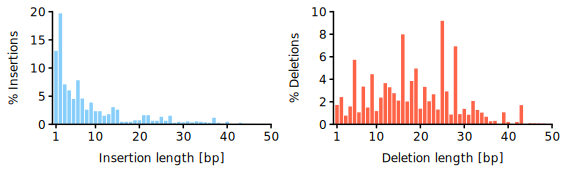

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 2.5), gridspec_kw={'width_ratios': [5, 5]})

sample = 'GFP-1_S2'
insertion_len[sample].divide(insertion_len[sample].sum()/100).plot(kind='bar',ax=ax[0], color='lightskyblue', width=0.8)
ax[0].set_xlim(-0.5, max(insertion_len[sample].index))
ax[0].set_xticks([0] + [x for x in range(9, max(insertion_len[sample].index),10)])
ax[0].set_xticklabels([1] + [x+1 for x in range(9, max(insertion_len[sample].index),10)], size=12, rotation=0)
ax[0].set_xlabel('Insertion length [bp]', labelpad=10, size=12)
ax[0].set_ylabel('% Insertions', labelpad=10, size=12)
ax[0].set_ylim(0, 20)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
for y in ax[0].get_yticklabels():
    y.set_size(12)
ax[0].spines['bottom'].set_linewidth(1.5)
ax[0].spines['left'].set_linewidth(1.5)
ax[0].tick_params(width=1.5, length=4)
ax[0].set_xlim(-0.8,49)

deletion_len[sample].divide(deletion_len[sample].sum()/100).plot(kind='bar',ax=ax[1], color='tomato', width=0.8)
ax[1].set_xlim(-0.5, max(deletion_len[sample].index))
ax[1].set_xticks([0] + [x for x in range(9, max(deletion_len[sample].index),10)])
ax[1].set_xticklabels([1] + [x+1 for x in range(9, max(deletion_len[sample].index),10)], size=12, rotation=0)
ax[1].set_xlabel('Deletion length [bp]', labelpad=10, size=12)
ax[1].set_ylabel('% Deletions', labelpad=10, size=12)
ax[1].set_ylim(0, 10)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
for y in ax[1].get_yticklabels():
    y.set_size(12)
ax[1].spines['bottom'].set_linewidth(1.5)
ax[1].spines['left'].set_linewidth(1.5)
ax[1].tick_params(width=1.5, length=4)
ax[1].set_xlim(-0.8,49)

plt.tight_layout()              
plt.show()

In [33]:
# fraction of in-frame indels
insertion_len[sample].loc[[i for i in insertion_len[sample].index if i%3==0]].sum()/insertion_len[sample].sum()

0.28597122302158273

## Supplementary figure

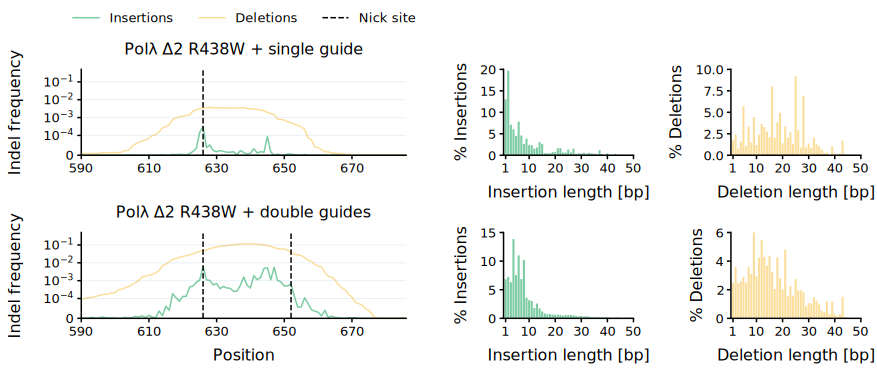

In [35]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(14, 4.5),
                        gridspec_kw={'width_ratios':[2.5,1,1], 'height_ratios':[1,1]})

font_size = 16
lgnd_size = 13

ax = axs[0:2, 0]

for n,f in enumerate(['GFP-1_S2', 'GFP-1-B_S3']):
    to_plot_in[f].plot(color='#7ccba2', ax=ax[n])
    to_plot_del[f].plot(color='#fcde9c', ax=ax[n])
    ymax = 0.5
    ax[n].set_ylim(0, ymax)
    ax[n].set_yscale('symlog', linthresh=1e-4)
    ax[n].set_xlim(625-35, 651+35)
    ax[n].set_xticks([i for i in range(625-35, 651+35, 20)])
    ax[n].set_xticklabels([i for i in range(625-35, 651+35, 20)], size=lgnd_size, rotation=0)
    for y in ax[n].get_yticklabels():
        y.set_size(lgnd_size)
    ax[n].set_title(titles[f], size=font_size, pad=15)
    ax[n].spines['right'].set_visible(False)
    ax[n].spines['left'].set_linewidth(1.5)
    ax[n].spines['top'].set_visible(False)
    ax[n].spines['bottom'].set_linewidth(1.5)
    ax[n].tick_params(width=1.5, length=4)
    ax[n].set_ylabel('Indel frequency', size=font_size, labelpad=20, color='k')
    guide_names = guides_by_sample[f]
    for guide_name in guide_names:
        nick = nick_sites[f][guide_name]
        if guide_name=='B':
            ax[n].vlines(nick, 0, ymax, color='k', linestyle='--')
        else:
            ax[n].vlines(nick, 0, ymax, color='k', linestyle='--',label='Nick site')
    for i in range(1,5):
        ax[n].hlines(10**(-i), 0, len(ampls[ampl_name]), linewidth=1, alpha=0.1)
    ax[n].set_yticks([], minor=True)
    ax[n].set_yticks([10**(-x) for x in range(1, 5)]+[0])

lgd = ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.8), title ='', prop={'size':lgnd_size}, ncol=3, frameon=False)
plt.setp(lgd.get_title(),fontsize=str(lgnd_size))
ax[-1].set_xlabel('Position', size=font_size, labelpad=10)

########################################################################################################
# INDEL LENGTH SINGLE

ax = axs[0, 1:3]

sample = 'GFP-1_S2'
insertion_len[sample].divide(insertion_len[sample].sum()/100).plot(kind='bar',ax=ax[0], color='#7ccba2', width=0.8)
ax[0].set_xlim(-0.5, max(insertion_len[sample].index))
ax[0].set_xticks([0] + [x for x in range(9, max(insertion_len[sample].index),10)])
ax[0].set_xticklabels([1] + [x+1 for x in range(9, max(insertion_len[sample].index),10)], size=lgnd_size, rotation=0)
ax[0].set_xlabel('Insertion length [bp]', labelpad=10, size=font_size)
ax[0].set_ylabel('% Insertions', labelpad=10, size=font_size)
ax[0].set_ylim(0, 20)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
for y in ax[0].get_yticklabels():
    y.set_size(lgnd_size)
ax[0].spines['bottom'].set_linewidth(1.5)
ax[0].spines['left'].set_linewidth(1.5)
ax[0].tick_params(width=1.5, length=4)
ax[0].set_xlim(-0.8,49)

deletion_len[sample].divide(deletion_len[sample].sum()/100).plot(kind='bar',ax=ax[1], color='#fcde9c', width=0.8)
ax[1].set_xlim(-0.5, max(deletion_len[sample].index))
ax[1].set_xticks([0] + [x for x in range(9, max(deletion_len[sample].index),10)])
ax[1].set_xticklabels([1] + [x+1 for x in range(9, max(deletion_len[sample].index),10)], size=lgnd_size, rotation=0)
ax[1].set_xlabel('Deletion length [bp]', labelpad=10, size=font_size)
ax[1].set_ylabel('% Deletions', labelpad=10, size=font_size)
ax[1].set_ylim(0, 10)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
for y in ax[1].get_yticklabels():
    y.set_size(lgnd_size)
ax[1].spines['bottom'].set_linewidth(1.5)
ax[1].spines['left'].set_linewidth(1.5)
ax[1].tick_params(width=1.5, length=4)
ax[1].set_xlim(-0.8,49)

########################################################################################################
# INDEL LENGTH DOUBLE

ax = axs[1, 1:3]

sample = 'GFP-1-B_S3'
insertion_len[sample].divide(insertion_len[sample].sum()/100).plot(kind='bar',ax=ax[0], color='#7ccba2', width=0.8)
ax[0].set_xlim(-0.5, max(insertion_len[sample].index))
ax[0].set_xticks([0] + [x for x in range(9, max(insertion_len[sample].index),10)])
ax[0].set_xticklabels([1] + [x+1 for x in range(9, max(insertion_len[sample].index),10)], size=lgnd_size, rotation=0)
ax[0].set_xlabel('Insertion length [bp]', labelpad=10, size=font_size)
ax[0].set_ylabel('% Insertions', labelpad=10, size=font_size)
ax[0].set_ylim(0, 15)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
for y in ax[0].get_yticklabels():
    y.set_size(lgnd_size)
ax[0].spines['bottom'].set_linewidth(1.5)
ax[0].spines['left'].set_linewidth(1.5)
ax[0].tick_params(width=1.5, length=4)
ax[0].set_xlim(-0.8,49)

deletion_len[sample].divide(deletion_len[sample].sum()/100).plot(kind='bar',ax=ax[1], color='#fcde9c', width=0.8)
ax[1].set_xlim(-0.5, max(deletion_len[sample].index))
ax[1].set_xticks([0] + [x for x in range(9, max(deletion_len[sample].index),10)])
ax[1].set_xticklabels([1] + [x+1 for x in range(9, max(deletion_len[sample].index),10)], size=lgnd_size, rotation=0)
ax[1].set_xlabel('Deletion length [bp]', labelpad=10, size=font_size)
ax[1].set_ylabel('% Deletions', labelpad=10, size=font_size)
ax[1].set_ylim(0, 6)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
for y in ax[1].get_yticklabels():
    y.set_size(lgnd_size)
ax[1].spines['bottom'].set_linewidth(1.5)
ax[1].spines['left'].set_linewidth(1.5)
ax[1].tick_params(width=1.5, length=4)
ax[1].set_xlim(-0.8,49)

plt.subplots_adjust(wspace=0.5, hspace=0.9)
#plt.tight_layout()

plt.show()